In [ ]:
#############################################################################
# zlib License
#
# (C) 2023 Zach Flowers, Murtaza Safdari <musafdar@cern.ch>
#
# This software is provided 'as-is', without any express or implied
# warranty.  In no event will the authors be held liable for any damages
# arising from the use of this software.
#
# Permission is granted to anyone to use this software for any purpose,
# including commercial applications, and to alter it and redistribute it
# freely, subject to the following restrictions:
#
# 1. The origin of this software must not be misrepresented; you must not
#    claim that you wrote the original software. If you use this software
#    in a product, an acknowledgment in the product documentation would be
#    appreciated but is not required.
# 2. Altered source versions must be plainly marked as such, and must not be
#    misrepresented as being the original software.
# 3. This notice may not be removed or altered from any source distribution.
#############################################################################

# Imports

In [1]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt
import logging
import i2c_gui
import i2c_gui.chips
from i2c_gui.usb_iss_helper import USB_ISS_Helper
from i2c_gui.fpga_eth_helper import FPGA_ETH_Helper
import numpy as np

from mpl_toolkits.axes_grid1 import make_axes_locatable
# import time
from tqdm import tqdm
# from i2c_gui.chips.etroc2_chip import register_decoding
import os, sys
import multiprocessing
os.chdir(f'/home/{os.getlogin()}/ETROC2/ETROC_DAQ')
import run_script
import importlib
importlib.reload(run_script)
import datetime
import pandas
from pathlib import Path
import subprocess
import sqlite3
from fnmatch import fnmatch
import scipy.stats as stats
import hist
import mplhep as hep
plt.style.use(hep.style.CMS)
from notebooks.notebook_helpers import *

from scripts.log_action import log_action_v2
from time import sleep

# Set defaults

In [17]:
# !!!!!!!!!!!!
# It is very important to correctly set the chip name, this value is stored with the data
chip_names = ["ET2_EPIR_Batch_1_1_HV220"]
chip_names = ["ET2_W12_5_3_HV240"]
chip_names = ["ET2_Pair3_HV290", "ET2_EPIR_Pair4_HV240", "ET2_EPIR_Pair5_HV220"]
chip_names = ["ET2_Pair3_HV290", "ET2_W12_5_3_HV240"]
chip_names = ["ET2_Pair3_HV285", "ET2_W12_5_3_HV240", "ET2_W12_2_3_HV120"]
chip_names = ["ET2_Pair3", "ET2_W12_5_3", "ET2_W12_5_5"]
chip_names = ["ET2_W12_5_3", "ET2_W12_5_5"]
#chip_names = ["ET2_Pair3", "ET2_W12_5_3"]
chip_fignames = chip_names
chip_figtitles = ["ETROC2 EPIR Batch 1-1 HV 220"]  # EPIR Batch 1-1
chip_figtitles = ["ETROC2 W12 5-3 HV 240"]
chip_figtitles = ["ETROC2 EPIR Pair 3 HV290", "ETROC2 W12 5-3 HV 240"]
chip_figtitles = ["ETROC2 EPIR Pair 3 HV 285", "ETROC2 W12 5-3 HV 240", "ETROC2 W12 2-3 HV 120"]
chip_figtitles = ["ETROC2 EPIR Pair 3", "ETROC2 W12 5-3", "ETROC2 W12 5-5"]
chip_figtitles = ["ETROC2 W12 5-3", "ETROC2 W12 5-5"]
#chip_figtitles = ["ETROC2 EPIR Pair 3", "ETROC2 W12 5-3"]

# 'The port name the USB-ISS module is connected to. Default: COM3'
port = "/dev/ttyACM0"
# I2C addresses for the pixel block and WS
chip_addresses = [0x60, 0x61, 0x62]
chip_addresses = [0x61, 0x62]
ws_addresses = [None, None, None]

# i2c_gui.__no_connect__ = False  # Set to fake connecting to an ETROC2 device
# i2c_gui.__no_connect_type__ = "echo"  # for actually testing readback
# #i2c_gui.__no_connect_type__ = "check"  # default behaviour

hostname = "192.168.2.3"

fig_outdir = Path('../ETROC-figures')
fig_outdir = fig_outdir / (datetime.date.today().isoformat() + '_Array_Test_Results')
fig_outdir.mkdir(exist_ok=True)
fig_path = str(fig_outdir)

# Make i2c_connection class object

In [18]:
# i2c_conn = self, port, chip_addresses, chip_names, chip_fc_delays
i2c_conn = i2c_connection(port,chip_addresses, ws_addresses,chip_names,[("1","1"), ("1","1"), ("1","1")])

In [19]:
i2c_conn.config_chips('00000100')

Peripherals set for chip: 0x61
Peripherals set for chip: 0x62


# Config chips

### Key is (Disable Pixels, Auto Cal, Chip Peripherals, Basic Peri Reg Check, Pixel Check)

In [20]:
# 0 - 0 - (disable & auto_cal all pixels) - (disable default all pixels) - (auto_TH_CAL) - (set basic peripherals) - (peripheral reg check) -  (pixel ID check)
i2c_conn.config_chips('00100111')

Passed pixel check for chip: 0x61
Passed peripheral write check for chip: 0x61
Peripherals set for chip: 0x61
Disabled pixels for chip: 0x61


Calibrating row: 100%|██████████| 16/16 [01:29<00:00,  5.58s/it]


Auto calibration finished for chip: 0x61
Passed pixel check for chip: 0x62
Passed peripheral write check for chip: 0x62
Peripherals set for chip: 0x62
Disabled pixels for chip: 0x62


Calibrating row: 100%|██████████| 16/16 [01:29<00:00,  5.58s/it]

Auto calibration finished for chip: 0x62


## Visualize the learned Baselines (BL) and Noise Widths (NW)

Note that the NW represents the full width on either side of the BL

In [21]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.show()

<Figure size 1000x1000 with 0 Axes>

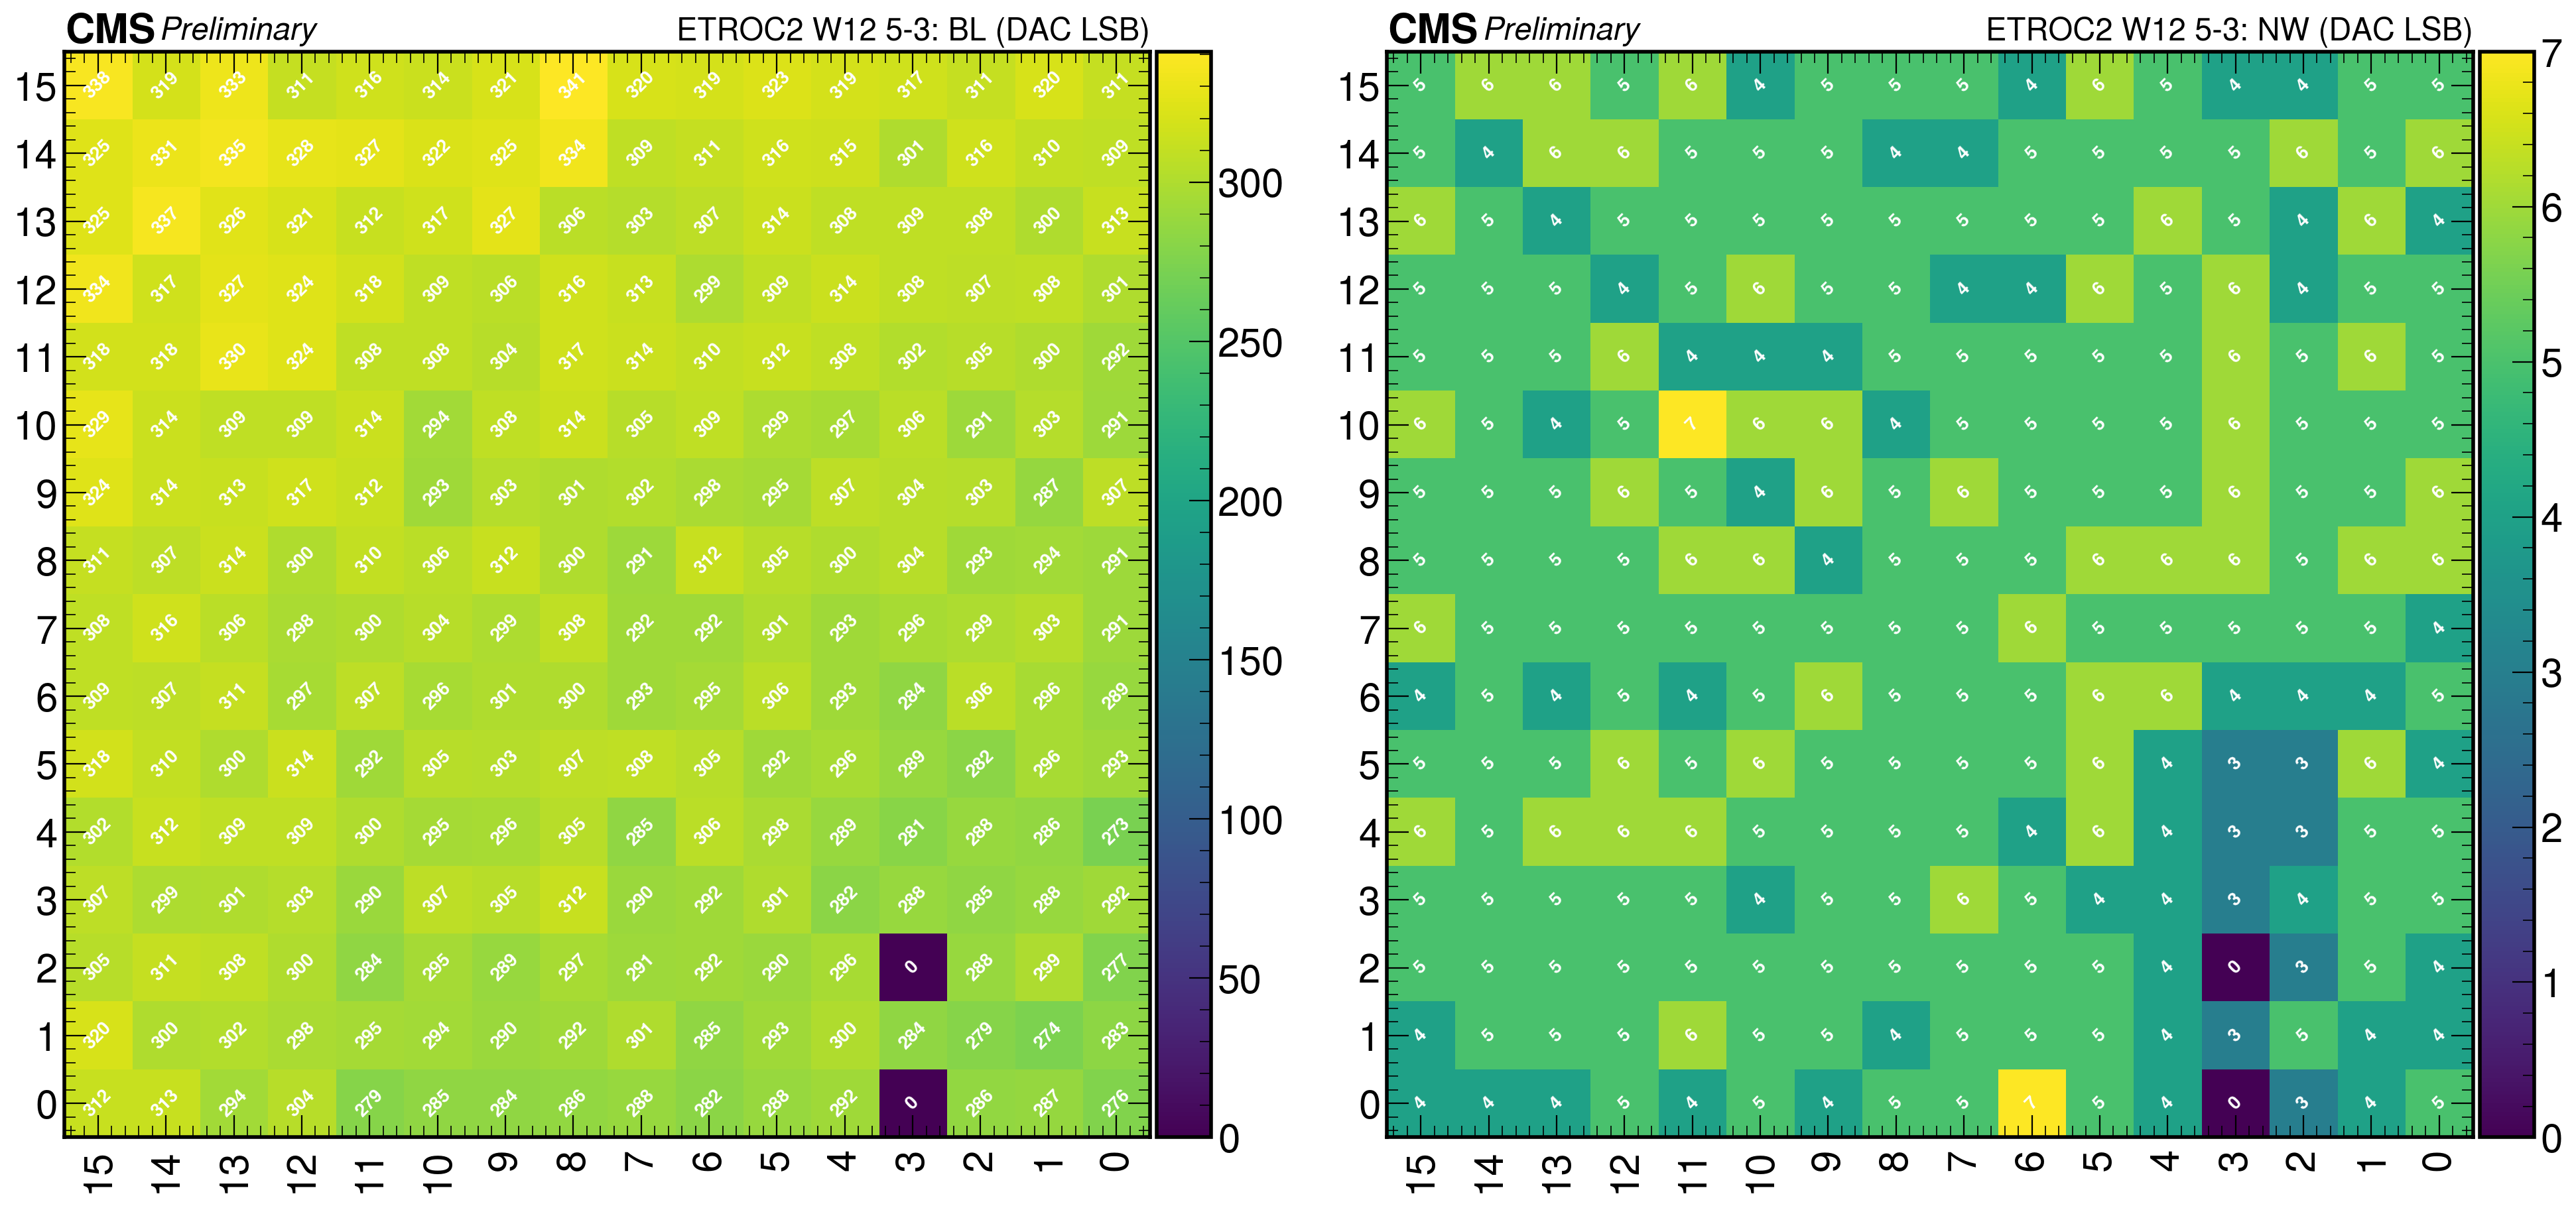

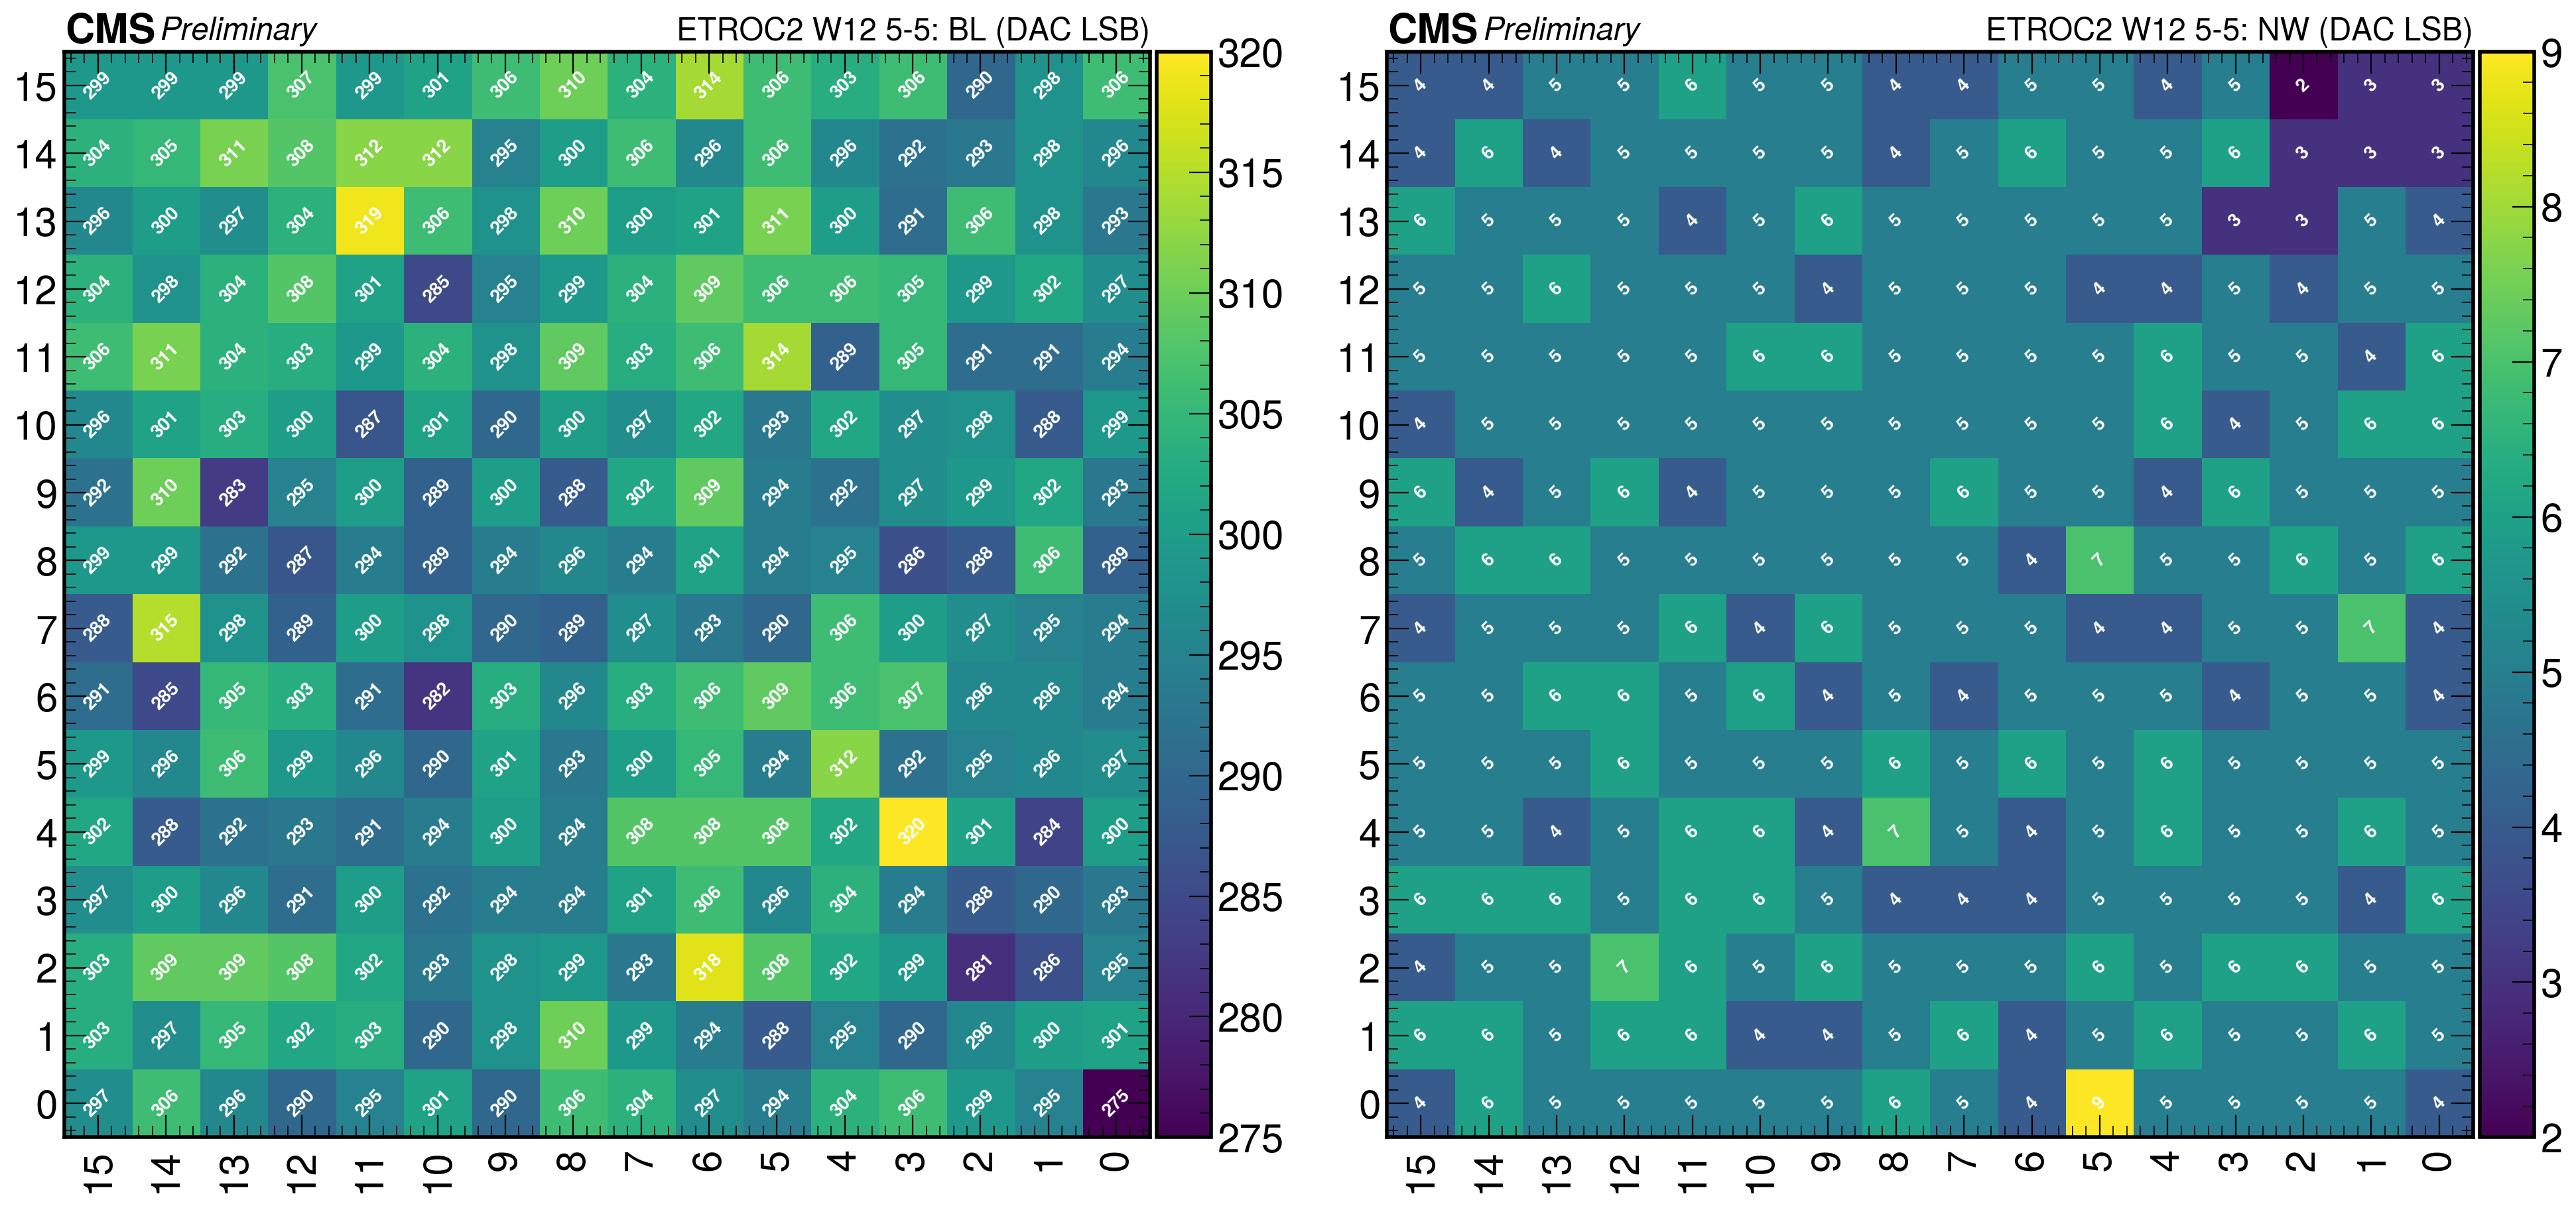

In [22]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable
for chip_address, chip_figname, chip_figtitle in zip(chip_addresses,chip_fignames,chip_figtitles):
    BL_map_THCal,NW_map_THCal,BL_df = i2c_conn.get_auto_cal_maps(chip_address)
    fig = plt.figure(dpi=200, figsize=(20,10))
    gs = fig.add_gridspec(1,2)

    ax0 = fig.add_subplot(gs[0,0])
    ax0.set_title(f"{chip_figtitle}: BL (DAC LSB)", size=17, loc="right")
    img0 = ax0.imshow(BL_map_THCal, interpolation='none')
    ax0.set_aspect("equal")
    ax0.invert_xaxis()
    ax0.invert_yaxis()
    plt.xticks(range(16), range(16), rotation="vertical")
    plt.yticks(range(16), range(16))
    hep.cms.text(loc=0, ax=ax0, fontsize=17, text="Preliminary")
    divider = make_axes_locatable(ax0)
    cax = divider.append_axes('right', size="5%", pad=0.05)
    fig.colorbar(img0, cax=cax, orientation="vertical")

    ax1 = fig.add_subplot(gs[0,1])
    ax1.set_title(f"{chip_figtitle}: NW (DAC LSB)", size=17, loc="right")
    img1 = ax1.imshow(NW_map_THCal, interpolation='none')
    ax1.set_aspect("equal")
    ax1.invert_xaxis()
    ax1.invert_yaxis()
    plt.xticks(range(16), range(16), rotation="vertical")
    plt.yticks(range(16), range(16))
    hep.cms.text(loc=0, ax=ax1, fontsize=17, text="Preliminary")
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size="5%", pad=0.05)
    fig.colorbar(img1, cax=cax, orientation="vertical")

    for x in range(16):
        for y in range(16):
            ax0.text(x,y,f"{BL_map_THCal.T[x,y]:.0f}", c="white", size=10, rotation=45, fontweight="bold", ha="center", va="center")
            ax1.text(x,y,f"{NW_map_THCal.T[x,y]:.0f}", c="white", size=10, rotation=45, fontweight="bold", ha="center", va="center")
    plt.tight_layout()
    plt.savefig(fig_path+"/BL_NW_"+chip_figname+"_"+datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")+".png")
    plt.show()

In [15]:
i2c_conn

In [16]:
for chip_address, chip_name in zip(chip_addresses, chip_names):
    i2c_conn.save_auto_cal_BL_map(chip_address, chip_name, "")
    i2c_conn.save_auto_cal_NW_map(chip_address, chip_name, "")

# Define pixels of interest

In [ ]:
# row_list = [14, 14, 14, 14]
# col_list = [6, 7, 8, 9]
# row_list = [15, 15, 15, 15]
# col_list = [6, 7, 8, 9]
# row_list = [14, 14, 15, 15]
# col_list = [6, 9, 6, 9]
# row_list = [14, 14, 14, 14, 15, 15, 15, 15]
# col_list = [6, 7, 8, 9, 6, 7, 8, 9]
row_list = [14, 3]
col_list = [6, 3]

scan_list = list(zip(row_list, col_list))
print(scan_list)

col_list, row_list = np.meshgrid(np.arange(16),np.arange(16))
scan_list = list(zip(row_list.flatten(),col_list.flatten()))

### Enable pixels of Interest

In [ ]:
i2c_conn.enable_select_pixels_in_chips(scan_list)

In [ ]:
offset = 0x08
for chip_address in chip_addresses[:]:
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    row_indexer_handle,_,_ = chip.get_indexer("row")
    column_indexer_handle,_,_ = chip.get_indexer("column")
    for row, col in scan_list:
        print(f"Operating on chip {hex(chip_address)} Pixel ({row},{col})")
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)    
        i2c_conn.pixel_decoded_register_write("QSel", format(0x14, '05b'), chip)
        i2c_conn.pixel_decoded_register_write("QInjEn", '0', chip)
        i2c_conn.pixel_decoded_register_write("TH_offset", format(offset, '06b'), chip)
    del chip, row_indexer_handle, column_indexer_handle

### Adjust offset

In [ ]:
offsets = {
    0x60: 0x09,
    0x61: 0x08,
#   0x62: 0x0a,
}
for chip_address in chip_addresses[:]:
    if chip_address not in offsets:
        continue
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    row_indexer_handle,_,_ = chip.get_indexer("row")
    column_indexer_handle,_,_ = chip.get_indexer("column")
    for row, col in scan_list:
        print(f"Operating on chip {hex(chip_address)} Pixel ({row},{col})")
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)    
        i2c_conn.pixel_decoded_register_write("TH_offset", format(offsets[chip_address], '06b'), chip)
    del chip, row_indexer_handle, column_indexer_handle

### Remove noisy pixels from Trigger

In [ ]:
noisy_pixels = {
    0x61: [
        (9, 5),
        (0, 3),
    ],
    0x62: [  # (row, col)
        #(10, 8),
        #(12, 14),
        #(14, 15),
        #(15, 13),
        #(15, 14),
        (15, 15),
        (15, 12),
        (15, 3),
        (13, 8),
        (13, 4),
        (13, 0),
        (11, 4),
        (10, 9),
        (9, 3),
        (8, 6),
        (7, 1),
        (6, 12),
        (2, 7),
        (0, 5),
        (0, 3),
    ],
}

for chip_address in chip_addresses[:]:
    if chip_address not in noisy_pixels:
        continue
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    row_indexer_handle,_,_ = chip.get_indexer("row")
    column_indexer_handle,_,_ = chip.get_indexer("column")
    for row, col in noisy_pixels[chip_address]:
        print(f"Masking from trigger of chip {hex(chip_address)} Pixel ({row},{col})")
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)
        i2c_conn.pixel_decoded_register_write("disTrigPath", "1", chip)
        i2c_conn.pixel_decoded_register_write("DAC", format(1023, '010b'), chip)
        i2c_conn.pixel_decoded_register_write("Bypass_THCal", "1", chip)

### Disable Pixels of Interest

In [ ]:
for chip_address in chip_addresses[:]:
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    row_indexer_handle,_,_ = chip.get_indexer("row")
    column_indexer_handle,_,_ = chip.get_indexer("column")
    for row,col in scan_list:
        i2c_conn.disable_pixel(row=row, col=col, verbose=True, chip_address=chip_address, chip=chip, row_indexer_handle=row_indexer_handle, column_indexer_handle=column_indexer_handle)
    del chip, row_indexer_handle, column_indexer_handle

# Calibrate PLL

In [ ]:
for chip_address in chip_addresses[:]:
    i2c_conn.calibratePLL(chip_address, chip=None)

# Calibrate FC

In [ ]:
for chip_address in chip_addresses[:]:
    i2c_conn.asyResetGlobalReadout(chip_address, chip=None)
    i2c_conn.asyAlignFastcommand(chip_address, chip=None)

In [ ]:
i2c_conn.calibratePLL(0x62, chip=None)
i2c_conn.asyResetGlobalReadout(0x62, chip=None)
i2c_conn.asyAlignFastcommand(0x62, chip=None)

# Run One Time DAQ to Set FPGA Firmware

In [ ]:
parser = run_script.getOptionParser()
# parser = parser_arguments.create_parser()
(options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -t 20 -o CanBeRemoved_Board0_NoLinkCheck -w -s 0x000C -p 0x000f -d 0x1800 -a 0x00bb".split())
IPC_queue = multiprocessing.Queue()
# f'main_process_Start_LEDs_Board0_NoLinkCheck'
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, None))
process.start()

IPC_queue.put('memoFC Start Triggerbit QInj L1A BCR')
while not IPC_queue.empty():
    pass
time.sleep(10)
IPC_queue.put('stop DAQ')
IPC_queue.put('memoFC Triggerbit')
while not IPC_queue.empty():
    pass
IPC_queue.put('allow threads to exit')
process.join()

del IPC_queue, process, parser

# Run DAQ with forced Linking and external L1A

In [ ]:
parser = run_script.getOptionParser()
(options, args) = parser.parse_args(args=f"-f --useIPC --reset_all_till_trigger_linked --hostname {hostname} -t 20 -o CanBeRemoved_Board013_LinkCheck_memoFC -v -w -s 0x0000 -p 0x000f -d 0xb800 -a 0x00bb".split())
IPC_queue = multiprocessing.Queue()
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Start_LEDs_Board013_LinkCheck_memoFC'))
process.start()

IPC_queue.put('memoFC Start Triggerbit QInj L1A BCR')
while not IPC_queue.empty():
    pass
time.sleep(10)
IPC_queue.put('stop DAQ')
IPC_queue.put('memoFC Triggerbit')
while not IPC_queue.empty():
    pass
IPC_queue.put('allow threads to exit')
process.join()

del IPC_queue, process, parser

# Run DAQ with Self-Trigger

### Find the right delay (use the middle of the three success modes, where both Qinj eges are caught)

In [ ]:
for inum in range(482, 488, 1):
    trigger_bit_delay = inum
    print(inum)
    parser = run_script.getOptionParser()
    (options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -t 20 -o CanBeRemoved_Board3_LinkCheck_selfTrigger_delay{inum} -v -w -s 0x0000 -p 0x000f -d {int('100011'+format(inum, '010b'), base=2)} -a 0x0088".split())
    IPC_queue = multiprocessing.Queue()
    process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Start_LEDs_Board3_LinkCheck_selfTrigger_delay{inum}'))
    process.start()

    IPC_queue.put('memoFC Start Triggerbit QInj BCR')
    while not IPC_queue.empty():
        pass
    time.sleep(10)
    IPC_queue.put('stop DAQ')
    IPC_queue.put('memoFC Triggerbit')
    while not IPC_queue.empty():
        pass
    IPC_queue.put('allow threads to exit')
    process.join()

    del IPC_queue, process, parser

### Self-triggering with Board 0

In [ ]:
trigger_bit_delay = int('000111'+format(485, '010b'), base=2)
parser = run_script.getOptionParser()
(options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -t 70 -o CanBeRemoved_Board0_LinkCheck_selfTrigger -v -w -s 0x0000 -p 0x000f -d {trigger_bit_delay} -a 0x0011 --counter_duration 0x0001 --clear_fifo".split())
IPC_queue = multiprocessing.Queue()
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Start_LEDs_Board0_LinkCheck_selfTrigger'))
process.start()

#IPC_queue.put('memoFC Start Triggerbit QInj BCR')
IPC_queue.put('memoFC Start Triggerbit BCR')
while not IPC_queue.empty():
    pass
time.sleep(60)
IPC_queue.put('stop DAQ')
IPC_queue.put('memoFC Triggerbit')
while not IPC_queue.empty():
    pass
IPC_queue.put('allow threads to exit')
process.join()

del IPC_queue, process, parser

### Self-triggering with Board 1

In [ ]:
trigger_bit_delay = int('001011'+format(484, '010b'), base=2)
parser = run_script.getOptionParser()
(options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -t 70 -o CanBeRemoved_Board1_LinkCheck_selfTrigger -v -w -s 0x0004 -p 0x000f -d {trigger_bit_delay} -a 0x0022 --counter_duration 0x0081 --clear_fifo".split())
IPC_queue = multiprocessing.Queue()
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Start_LEDs_Board1_LinkCheck_selfTrigger'))
process.start()

IPC_queue.put('memoFC Start Triggerbit QInj BCR')
while not IPC_queue.empty():
    pass
time.sleep(60)
IPC_queue.put('stop DAQ')
IPC_queue.put('memoFC Triggerbit')
while not IPC_queue.empty():
    pass
IPC_queue.put('allow threads to exit')
process.join()

del IPC_queue, process, parser

### Self-triggering with Board 3

In [ ]:
trigger_bit_delay = int('100011'+format(484, '010b'), base=2)
parser = run_script.getOptionParser()
(options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -t 70 -o CanBeRemoved_Board3_LinkCheck_selfTrigger -v -w -s 0x000C -p 0x000f -d {trigger_bit_delay} -a 0x0088 --counter_duration 0x0201 --clear_fifo".split())
IPC_queue = multiprocessing.Queue()
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Start_LEDs_Board3_LinkCheck_selfTrigger'))
process.start()

IPC_queue.put('memoFC Start Triggerbit QInj BCR')
while not IPC_queue.empty():
    pass
time.sleep(60)
IPC_queue.put('stop DAQ')
IPC_queue.put('memoFC Triggerbit')
while not IPC_queue.empty():
    pass
IPC_queue.put('allow threads to exit')
process.join()

del IPC_queue, process, parser

### Self-Trigger with 0+1+2 and DAQ 

#### With Qinj

In [ ]:
trigger_bit_delay = int('101111'+format(485, '010b'), base=2)
parser = run_script.getOptionParser()
(options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -t 20 -o CanBeRemoved_Board013_LinkCheck_selfTrigger013 -v -w -s 0x0000 -p 0x000f -d {trigger_bit_delay} -a 0x00bb --counter_duration 0x0001 --clear_fifo".split())
IPC_queue = multiprocessing.Queue()
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Start_LEDs_Board013_LinkCheck_selfTrigger013'))
process.start()

IPC_queue.put('memoFC Start Triggerbit QInj BCR')
while not IPC_queue.empty():
    pass
time.sleep(10)
IPC_queue.put('stop DAQ')
IPC_queue.put('memoFC Triggerbit')
while not IPC_queue.empty():
    pass
IPC_queue.put('allow threads to exit')
process.join()

del IPC_queue, process, parser

# Run DAQ - Laser Mode

For Zhenyu

In [ ]:
trigger_bit_delay = int('000111'+format(485, '010b'), base=2)
parser = run_script.getOptionParser()
(options, args) = parser.parse_args(args=f"-f --useIPC --reset_all_till_trigger_linked --hostname {hostname} -t 200 -o LaserMode_Board0_LinkCheck_selfTrigger0_2mins -v -w -s 0x0000 -p 0x000f -d {trigger_bit_delay} -a 0x0011 --counter_duration 0x0001".split())
IPC_queue = multiprocessing.Queue()
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_LaserMode_Board0_LinkCheck_selfTrigger0_2mins'))
process.start()

IPC_queue.put('memoFC Start Triggerbit BCR')
while not IPC_queue.empty():
    pass
time.sleep(120)
IPC_queue.put('stop DAQ')
IPC_queue.put('memoFC Triggerbit')
while not IPC_queue.empty():
    pass
IPC_queue.put('allow threads to exit')
process.join()

del IPC_queue, process, parser

# Run DAQ - Cosmics Mode

### Test and set all firmware options

In [ ]:
trigger_bit_delay = int('000111'+format(485, '010b'), base=2)
parser = run_script.getOptionParser()
(options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -t 200 -o CanBeRemoved_Board013_LinkCheck_selfTrigger03_2mins_offset1e -v -w -s 0x0000 -p 0x000f -d {trigger_bit_delay} -a 0x0011 --counter_duration 0x0001 --skip_binary -l 100000 --compressed_translation --ssd".split())
IPC_queue = multiprocessing.Queue()
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Start_LEDs_Board013_LinkCheck_selfTrigger03_2mins_offset1e'))
process.start()

IPC_queue.put('memoFC Start Triggerbit BCR')
while not IPC_queue.empty():
    pass
time.sleep(120)
IPC_queue.put('stop DAQ')
IPC_queue.put('memoFC Triggerbit')
while not IPC_queue.empty():
    pass
IPC_queue.put('allow threads to exit')
process.join()

del IPC_queue, process, parser

### Calibrate and Run at Specified Intervals

In [ ]:
num_attempts = 10
time_in_seconds = 900
cosmics_offset = 1
print("Total runtime (s):", num_attempts*time_in_seconds)

In [ ]:
for attempt in range(num_attempts):
    for chip_address, chip_name in zip(chip_addresses, chip_names):
        for row, col in scan_list:
            i2c_conn.auto_cal_pixel(chip_name=chip_name, row=row, col=col, verbose=False, chip_address=chip_address, chip=None, data=None, row_indexer_handle=None, column_indexer_handle=None)

    trigger_bit_delay = int('100111'+format(485, '010b'), base=2)
    parser = run_script.getOptionParser()
    (options, args) = parser.parse_args(args=f"--useIPC --reset_all_till_trigger_linked --hostname {hostname} -t {time_in_seconds+100} -o Cosmics_Board013_LinkCheck_selfTrigger03_{attempt} -v -w --skip_binary -l 100000 --compressed_translation".split())
    IPC_queue = multiprocessing.Queue()
    process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_Cosmics_Board013_LinkCheck_selfTrigger03'))
    process.start()
    IPC_queue.put('memoFC Start Triggerbit BCR')
    while not IPC_queue.empty():
        pass
    time.sleep(120)
    IPC_queue.put('stop DAQ')
    IPC_queue.put('memoFC Triggerbit')
    while not IPC_queue.empty():
        pass
    IPC_queue.put('allow threads to exit')
    process.join()

    del IPC_queue, process, parser

# Take data

In [ ]:
trigger_bit_delay = int('000111'+format(485, '010b'), base=2)
trigger_bit_delay = int('100011'+format(484, '010b'), base=2)
total_time = 8 * 60 * 60  # Time in seconds for overall run
daq_time = 300  # Time in seconds for data taking process
process_time = daq_time + 10
from math import ceil
iterations = ceil(total_time/process_time)

for it in range(iterations):
    parser = run_script.getOptionParser()
    (options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -t {process_time} -o SelfTrigger_{chip_names[1]}_Readout_offset{offset}_lowpower_cosmics_loop_{it} -v -w -s 0x000C -p 0x000f -d {trigger_bit_delay} -a 0x0088 --counter_duration 0x0001 --ssd --compressed_translation --skip_binary".split())
    IPC_queue = multiprocessing.Queue()
    process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_SelfTrigger_{chip_names[1]}_Readout_offset{offset}_lowpower_cosmics_loop_{it}'))
    process.start()

    IPC_queue.put('memoFC Start Triggerbit BCR')
    while not IPC_queue.empty():
        pass
    time.sleep(daq_time)
    IPC_queue.put('stop DAQ')
    IPC_queue.put('memoFC Triggerbit')
    while not IPC_queue.empty():
        pass
    IPC_queue.put('allow threads to exit')
    process.join()

    del IPC_queue, process, parser

In [ ]:
IPC_queue.put('stop DAQ')
IPC_queue.put('memoFC Triggerbit')
IPC_queue.put('allow threads to exit')
process.join()

# Take data, with baseline scan every N minutes

In [ ]:
trigger_bit_delay = int('000111'+format(484, '010b'), base=2)

baseline_every = 60 * 60 # seconds

total_time = 4 * 60 * 60  # Time in seconds for overall run

daq_time = 300  # Time in seconds for data taking process
process_time = daq_time + 10

from math import ceil
approx_iterations = ceil(total_time/process_time)

print(f'Will run approximately {approx_iterations} loops')

iteration = 0
start_time = time.time()
last_baseline_time = start_time - baseline_every - 1
while True:
    current_time = time.time()
    elapsed_time = current_time - start_time

    if current_time - last_baseline_time > baseline_every:
        i2c_conn.auto_calibration(chip_addresses[0], chip_names[0])
        last_baseline_time = time.time()

    parser = run_script.getOptionParser()
    (options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -t {process_time} -o SelfTrigger_{chip_names[0]}_Readout_offset{offset}_lowpower_cosmics_loop_{iteration} -v -w -s 0x0000 -p 0x000f -d {trigger_bit_delay} -a 0x0011 --counter_duration 0x0001 --ssd --compressed_translation --skip_binary".split())
    IPC_queue = multiprocessing.Queue()
    process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, f'main_process_SelfTrigger_{chip_names[0]}_Readout_offset{offset}_lowpower_cosmics_loop_{iteration}'))
    process.start()

    IPC_queue.put('memoFC Start Triggerbit BCR')
    while not IPC_queue.empty():
        pass
    time.sleep(daq_time)
    IPC_queue.put('stop DAQ')
    IPC_queue.put('memoFC Triggerbit')
    while not IPC_queue.empty():
        pass
    IPC_queue.put('allow threads to exit')
    process.join()

    del IPC_queue, process, parser

    if elapsed_time > total_time:
        break
    iteration += 1

# Redo baselines

In [ ]:
i2c_conn.config_chips('00010000')
i2c_conn.enable_select_pixels_in_chips(scan_list)
offset = 0x08
for chip_address in chip_addresses[:]:
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    row_indexer_handle,_,_ = chip.get_indexer("row")
    column_indexer_handle,_,_ = chip.get_indexer("column")
    for row, col in scan_list:
        print(f"Operating on chip {hex(chip_address)} Pixel ({row},{col})")
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)    
        i2c_conn.pixel_decoded_register_write("QSel", format(0x14, '05b'), chip)
        i2c_conn.pixel_decoded_register_write("QInjEn", '0', chip)
        i2c_conn.pixel_decoded_register_write("TH_offset", format(offset, '06b'), chip)
    del chip, row_indexer_handle, column_indexer_handle

In [ ]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable
for chip_address, chip_figname, chip_figtitle in zip(chip_addresses,chip_fignames,chip_figtitles):
    BL_map_THCal,NW_map_THCal,BL_df = i2c_conn.get_auto_cal_maps(chip_address)
    fig = plt.figure(dpi=200, figsize=(20,10))
    gs = fig.add_gridspec(1,2)

    ax0 = fig.add_subplot(gs[0,0])
    ax0.set_title(f"{chip_figtitle}: BL (DAC LSB)", size=17, loc="right")
    img0 = ax0.imshow(BL_map_THCal, interpolation='none')
    ax0.set_aspect("equal")
    ax0.invert_xaxis()
    ax0.invert_yaxis()
    plt.xticks(range(16), range(16), rotation="vertical")
    plt.yticks(range(16), range(16))
    hep.cms.text(loc=0, ax=ax0, fontsize=17, text="Preliminary")
    divider = make_axes_locatable(ax0)
    cax = divider.append_axes('right', size="5%", pad=0.05)
    fig.colorbar(img0, cax=cax, orientation="vertical")

    ax1 = fig.add_subplot(gs[0,1])
    ax1.set_title(f"{chip_figtitle}: NW (DAC LSB)", size=17, loc="right")
    img1 = ax1.imshow(NW_map_THCal, interpolation='none')
    ax1.set_aspect("equal")
    ax1.invert_xaxis()
    ax1.invert_yaxis()
    plt.xticks(range(16), range(16), rotation="vertical")
    plt.yticks(range(16), range(16))
    hep.cms.text(loc=0, ax=ax1, fontsize=17, text="Preliminary")
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size="5%", pad=0.05)
    fig.colorbar(img1, cax=cax, orientation="vertical")

    for x in range(16):
        for y in range(16):
            ax0.text(x,y,f"{BL_map_THCal.T[x,y]:.0f}", c="white", size=10, rotation=45, fontweight="bold", ha="center", va="center")
            ax1.text(x,y,f"{NW_map_THCal.T[x,y]:.0f}", c="white", size=10, rotation=45, fontweight="bold", ha="center", va="center")
    plt.tight_layout()
    plt.savefig(fig_path+"/BL_NW_"+chip_figname+"_"+datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")+".png")
    plt.show()

# Disconnect I2C Device

In [ ]:
del i2c_conn

# Store BL, NW dataframe for later use

In [ ]:
outdir = Path('/run/media/daq/T7')
outdir = outdir / (datetime.date.today().isoformat() + '_Array_Test_Results')
outdir.mkdir(exist_ok=True)
outfile = outdir / (chip_name+"_BaselineAt_" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M") + ".csv")
BL_df.to_csv(outfile, index=False)

In [ ]:
### Store BL, NW dataframe for later use
outdir = Path('/run/media/daq/T7')
outdir = outdir / (datetime.date.today().isoformat() + '_Array_Test_Results')
outdir.mkdir(exist_ok=True)
outfile = outdir / (chip_name+"_BaselineAt_" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M") + ".csv")
BL_df.to_csv(outfile, index=False)
new_columns = {
    'note': f'{chip_figname}',
}

for col in new_columns:
    BL_df[col] = new_columns[col]

outdir = Path('../ETROC-Data')
outfile = outdir / 'BaselineHistory.sqlite'

init_cmd = [
    'cd ' + str(outdir.resolve()),
    'git stash -u',
    'git pull',
]
end_cmd = [
    'cd ' + str(outdir.resolve()),
    'git add BaselineHistory.sqlite',
    'git commit -m "Added new history entry"',
    'git push',
    'git stash pop',
    'git stash clear',
]
init_cmd = [x + '\n' for x in init_cmd]
end_cmd  = [x + '\n' for x in end_cmd]

p = subprocess.Popen(
    '/bin/bash',
    stdin=subprocess.PIPE,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    encoding="utf-8",
    )

# for cmd in init_cmd:
#     p.stdin.write(cmd + "\n")
# p.stdin.close()
# p.wait()

# print(p.stdout.read())

with sqlite3.connect(outfile) as sqlconn:
    BL_df.to_sql('baselines', sqlconn, if_exists='append', index=False)

p = subprocess.Popen(
    '/bin/bash',
    stdin=subprocess.PIPE,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    encoding="utf-8",
    )

# for cmd in end_cmd:
#     p.stdin.write(cmd + "\n")
# p.stdin.close()
# p.wait()

# p.stdin.close()

# print(p.stdout.read())
